In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1+cu121
0.20.1+cu121


'cuda'

In [ ]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10(root="data",
                     train=True,
                     download=True,
                     transform=ToTensor(),
                     target_transform=None)

test_data = CIFAR10(root="data",
                     train=False,
                     download=True,
                     transform=ToTensor(),
                     target_transform=None)

len(train_data), len(test_data)

100%|██████████| 170M/170M [00:03<00:00, 46.8MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


(50000, 10000)

In [ ]:
class_names = train_data.classes
len(class_names), class_names[7]

(10, 'horse')

In [ ]:
train_data[0][0].shape

torch.Size([3, 32, 32])

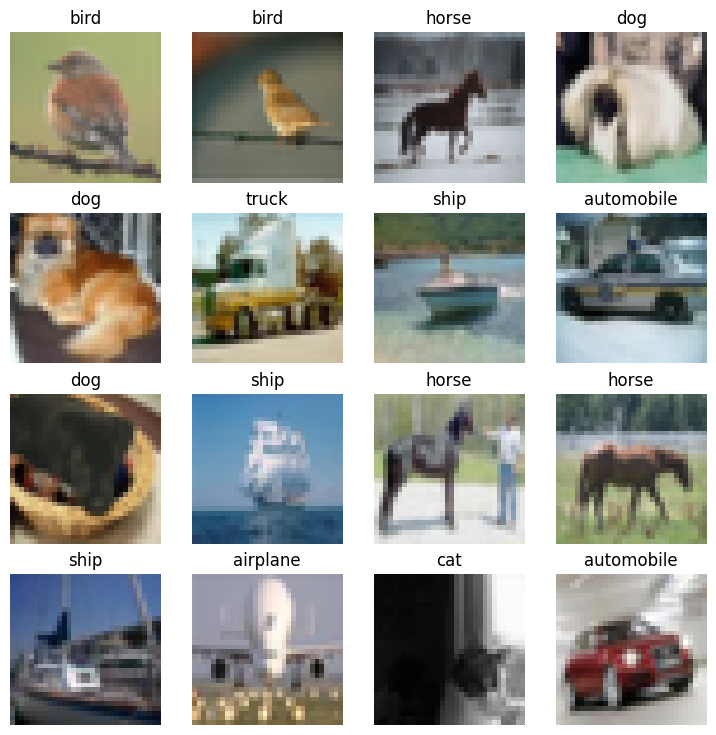

In [ ]:
# torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, 1 + rows * cols):
  rand_idx = torch.randint(1, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
  plt.axis(False)
  plt.title(class_names[label])

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

len(train_dataloader), len(test_dataloader)

(1563, 313)

In [ ]:
class CIFARModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=hidden_units * 4 * 4,
                  out_features=hidden_units * 2 * 2),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=hidden_units * 2 * 2,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [ ]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through the data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # outputs model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
# Create test_step()
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through the data loader data batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X) # outputs model logits

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  # Adjust metrics to get the average loss and accuracy per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update the reuslts dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

In [ ]:
LEARNING_RATE = 0.003

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = CIFARModel(input_shape=3,
                   hidden_units=24,
                   output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LEARNING_RATE)

In [ ]:
from timeit import default_timer as timer

start_time = timer()

train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=20,
      device=device)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3501 | Train acc: 0.5163 | Test loss: 1.1156 | Test acc: 0.6096
Epoch: 1 | Train loss: 0.9512 | Train acc: 0.6660 | Test loss: 0.8922 | Test acc: 0.6916
Epoch: 2 | Train loss: 0.8492 | Train acc: 0.7023 | Test loss: 0.8293 | Test acc: 0.7133
Epoch: 3 | Train loss: 0.7798 | Train acc: 0.7275 | Test loss: 0.7430 | Test acc: 0.7463
Epoch: 4 | Train loss: 0.7359 | Train acc: 0.7458 | Test loss: 0.7603 | Test acc: 0.7383
Epoch: 5 | Train loss: 0.7071 | Train acc: 0.7546 | Test loss: 0.6897 | Test acc: 0.7644
Epoch: 6 | Train loss: 0.6747 | Train acc: 0.7668 | Test loss: 0.7191 | Test acc: 0.7519
Epoch: 7 | Train loss: 0.6502 | Train acc: 0.7755 | Test loss: 0.6938 | Test acc: 0.7622
Epoch: 8 | Train loss: 0.6279 | Train acc: 0.7822 | Test loss: 0.7037 | Test acc: 0.7611
Epoch: 9 | Train loss: 0.6077 | Train acc: 0.7889 | Test loss: 0.6703 | Test acc: 0.7722
Epoch: 10 | Train loss: 0.5910 | Train acc: 0.7945 | Test loss: 0.6570 | Test acc: 0.7785
Epoch: 11 | Train lo

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([3, 32, 32])

In [ ]:
predictions = make_predictions(model=model,
                               data=test_samples,
                               device=device).argmax(dim=1)

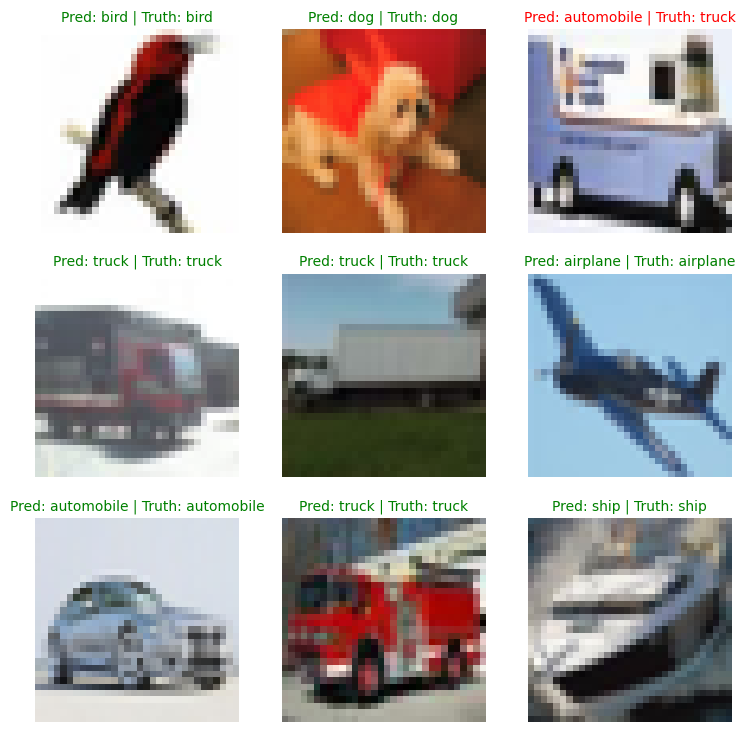

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(sample.squeeze().permute(1, 2, 0), cmap="gray")
  plt.axis(False)

  pred_label = class_names[predictions[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

In [ ]:
# See if required packages are installed and if not, install them
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 19.4 MB/s eta 0:00:00
mlxtend version: 0.23.3


In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predictions with the trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to the target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # put prediciton on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate the list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([3, 8, 8,  ..., 5, 1, 7])

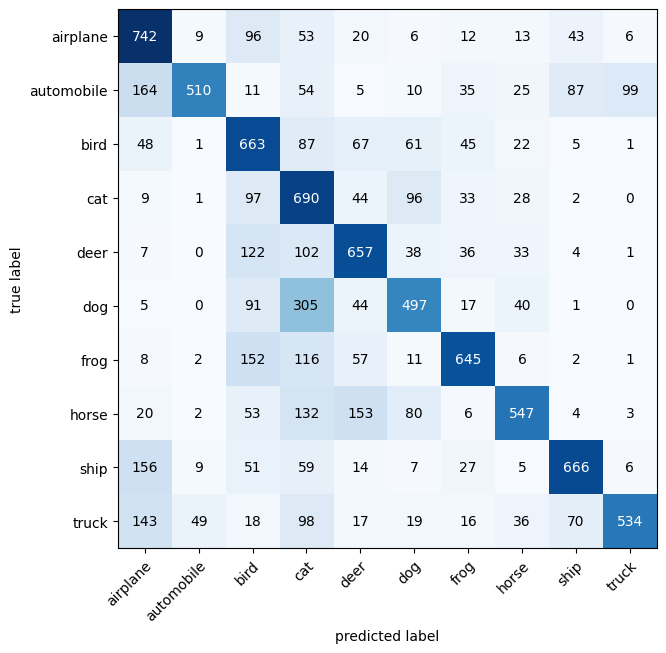

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

# 2. Setup a confusion matrix instance and compare predictions to the targets
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)